In [50]:
import copy
import ctypes
import ctypes.util
from functools import wraps

import numpy
from numpy.ctypeslib import ndpointer
from scipy import interpolate

# from ..util import _load_extension_libs, multi
# from ..util.conversion import physical_conversion
# from .Potential import Potential
import numpy as np


import numpy
from galpy.potential import interpRZPotential

class DirectInterpRZPotential(interpRZPotential):
    def __init__(self, RZPot=None,rgrid=(numpy.log(0.01),numpy.log(20.),101),
                 zgrid=(0.,1.,101),logR=True,
                 interpPot=False,interpRforce=False,interpzforce=False,
                 interpDens=False,
                 interpvcirc=False,
                 interpdvcircdr=False,
                 interpepifreq=False,interpverticalfreq=False,
                 ro=None,vo=None,
                 use_c=False,enable_c=False,zsym=True,
                 numcores=None,
                 densityGrid=None,
                 directPotentialGrid=None,
                 directRGrid=None,
                 directzGrid=None,
                 fallbackPotential=None,
                 directDensGrid=None):
        # if not roSet: self._roSet= False
        # if not voSet: self._voSet= False
        self._origPot= RZPot
        self._rgrid= numpy.linspace(*rgrid)
        self._logR= logR
        if self._logR:
            self._rgrid= numpy.exp(self._rgrid)
            self._logrgrid= numpy.log(self._rgrid)
        self._zgrid= numpy.linspace(*zgrid)
        self._interpPot= interpPot
        self._interpRforce= interpRforce
        self._interpzforce= interpzforce
        self._interpDens= interpDens
        self._interpvcirc= interpvcirc
        self._interpdvcircdr= interpdvcircdr
        self._interpepifreq= interpepifreq
        self._interpverticalfreq= interpverticalfreq
        #self._enable_c= enable_c*ext_loaded
        # self.hasC= self._enable_c
        self._zsym= zsym
        self._densityGrid = densityGrid
        self._directPotentialGrid = directPotentialGrid
        self._directRGrid = directRGrid
        self.directzGrid = directzGrid
        self._fallbackPotential = fallbackPotential
        self.directDensGrid = directDensGrid

        #potential interpolation
        self._potInterp= interpolate.RectBivariateSpline(self._directRGrid,
                                                                 self.directzGrid,
                                                                 self._directPotentialGrid,
                                                                 kx=3,ky=3,s=0.)
        self.used_fallback = False
        self.densInterp = interpolate.RectBivariateSpline(self._directRGrid,
                                                                 self.directzGrid,
                                                                 self.directDensGrid,
                                                                 kx=3,ky=3,s=0.)


        # Rforce interpolation


    def _evaluate(self,R,z,phi=0.,t=0.):
        from galpy.potential import evaluatePotentials
        if self._interpPot:
            out= numpy.empty(R.shape)
            indx= (R >= self._directRGrid[0])*(R <= self._directRGrid[-1])\
                *(z <= self.directzGrid[-1])*(z >= self.directzGrid[0])
            if numpy.sum(indx) > 0:
                if self._logR:
                    out[indx]= self._potInterp.ev(z[indx],numpy.log(R[indx]))
                else:
                    # out[indx]= self._potInterp.ev(R[indx],z[indx])
                    out[indx]= self._potInterp.ev(z[indx],R[indx])

            if numpy.sum(True^indx) > 0:
                if self.used_fallback==False:
                    print( "Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.")
                out[True^indx]= evaluatePotentials(self._fallbackPotential, R[True^indx]*u.kpc,z[True^indx]*u.kpc, quantity=True, ro=8,vo=220)#evaluatePotentials(self._fallbackPotential,
                                                   #R[True^indx],
                                                   #z[True^indx], ro=10, vo=100)
                used_fallback = True
            return out
        else:
            print("Fallback potential used, rather than interpolation.")
            return evaluatePotentials(self._fallbackPotential,R,z)

    # def _Rforce(self,R,z,phi=0.,t=0.):
    #     from galpy.potential import evaluatePotentials
    #     if self._interpRforce:
    #         out= numpy.empty(R.shape)
    #         indx= (R >= self._directRGrid[0])*(R <= self._directRGrid[-1])\
    #             *(z <= self.directzGrid[-1])*(z >= self.directzGrid[0])
    #         if numpy.sum(indx) > 0:
    #             if False:
    #                 pass
    #             else:
    #                 if self._logR:
    #                     out[indx]= self._rforceInterp.ev(numpy.log(R[indx]),z[indx])
    #                 else:
    #                     # out[indx]= self._rforceInterp.ev(R[indx],z[indx])
    #                     out[indx]= self._rforceInterp.ev(z[indx],R[indx])
    #
    #         if numpy.sum(True^indx) > 0:
    #             out[True^indx]= evaluateRforces(self._origPot,
    #                                             R[True^indx],
    #                                             z[True^indx])
    #         return out
    #     else:
    #         return evaluateRforces(self._origPot,R,z)

    def _Rforce(self, r_grid, z_grid):
        #Important note: this function takes in distances (r_grid and z_grid) and outputs an RForce in km/s/Myr, and will not output correct results if it is given parameters with other units
        from galpy.potential import evaluatePotentials
        grid = np.zeros((len(z_grid),len(r_grid)))*u.km/u.s/u.Myr
        delta = r_grid[1] - r_grid[0]
        for i,r in enumerate(r_grid):
            for j,z in enumerate(z_grid):
                #print(self._evaluate((r+delta).value,z.value), self._evaluate((r).value,z.value), r,z, self._evaluate((r+delta).value,z.value) - self._evaluate((r).value,z.value), delta)

                grid[j][i] = (((self._evaluate((r+delta).value,z.value) - self._evaluate((r).value,z.value)) / (delta.to(u.km))) * u.km**2/u.s**2).to(u.km/u.s/u.Myr)
        return -grid

    def _vcirc(self, R_grid):
        R_force = self._Rforce(R_grid,np.array([0])*u.kpc)
        v_c = R_grid[:] * -R_force[0,:]
        v_c = np.sqrt(v_c).to(u.km/u.s)
        return v_c

    def dens_eval(self, R,z,phi=0.,t=0.):
        if self._interpDens:
            out= numpy.empty(R.shape)
            indx= True#(R >= self._directRGrid[0])*(R <= self._directRGrid[-1])\
                #*(z <= self.directzGrid[-1])*(z >= self.directzGrid[0])
            if numpy.sum(indx) > 0:
                if False:
                    pass
                else:
                    if self._logR:
                        out[indx]= self.densInterp.ev(numpy.log(R[indx]),z[indx])
                    else:
                        # out[indx]= self._potInterp.ev(R[indx],z[indx])
                        out[indx]= self.densInterp.ev(z[indx],R[indx])

            if numpy.sum(True^indx) > 0:
                if self.used_fallback==False:
                    print( "Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.")
                out[True^indx]= evaluatePotentials(self._fallbackPotential, R[True^indx]*u.kpc,z[True^indx]*u.kpc, quantity=True, ro=10,vo=100)#evaluatePotentials(self._fallbackPotential,
                                                   #R[True^indx],
                                                   #z[True^indx], ro=10, vo=100)
                used_fallback = True
            return out
        else:
            pass







C:\Users\alegb\anaconda3\lib\site-packages\galpy\potential\PowerSphericalPotentialwCutoff.py:94: RuntimeWarning: invalid value encountered in true_divide
  out= 2.*numpy.pi*self.rc**(3.-self.alpha)*(1/self.rc*special.gamma(1.-self.alpha/2.)*special.gammainc(1.-self.alpha/2.,(r/self.rc)**2.)-special.gamma(1.5-self.alpha/2.)*special.gammainc(1.5-self.alpha/2.,(r/self.rc)**2.)/r)

C:\Users\alegb\anaconda3\lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:1372: RuntimeWarning: divide by zero encountered in true_divide
  out= -special.xlogy(1./r,1.+r/self.a) # stable as r -> infty

C:\Users\alegb\anaconda3\lib\site-packages\galpy\potential\PowerSphericalPotentialwCutoff.py:292: RuntimeWarning: divide by zero encountered in true_divide
  return 1./r**self.alpha*numpy.exp(-(r/self.rc)**2.)

C:\Users\alegb\anaconda3\lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:195: RuntimeWarning: divide by zero encountered in true_divide
  return (self.a/r)**self.alpha/(1.+r/s

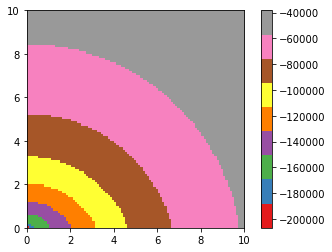

-84138.64027737106 km2 / s2
-38292.70042336392 km2 / s2


In [56]:

# Setting up test grid - NFWProfile
from galpy.potential import MWPotential2014
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from galpy.potential import evaluatePotentials
from galpy.potential import evaluateDensities
R_grid = np.linspace(0,10,100)*u.kpc
z_grid = np.linspace(0,10,100)*u.kpc
potential_grid = np.zeros((100,100))*u.km**2/u.s**2
dens_grid = np.zeros((100,100))*u.M_sun/u.pc**3
for i,z in enumerate(z_grid):
    potential_grid[i,:] = evaluatePotentials(MWPotential2014,R_grid,z,quantity=True,ro=8,vo=220)  #MWPotential2014[2](R_grid,z,quantity=True,ro=8,vo=220) #+ MWPotential2014[1](R_grid,z,quantity=True,ro=10,vo=100)+ MWPotential2014[2](R_grid,z,quantity=True,ro=10,vo=100)
    dens_grid[i,:] = evaluateDensities(MWPotential2014,R_grid,z,quantity=True,ro=8,vo=220)
plt.imshow(potential_grid, interpolation='nearest', extent =[R_grid.min().value, R_grid.max().value, z_grid.min().value, z_grid.max().value], cmap='Set1',  origin='lower')
plt.colorbar()
plt.show()
print(MWPotential2014[2](10*u.kpc,10*u.kpc, quantity=True, ro=8,vo=220))
print(potential_grid[-1,-1])

In [58]:
# Testing the interpolation method from DirectInterpRZPotential

ip = DirectInterpRZPotential(directPotentialGrid=potential_grid, directRGrid=R_grid.value, directzGrid=z_grid.value, interpPot=True, logR=False, fallbackPotential=MWPotential2014[2], interpDens=True, directDensGrid=dens_grid)
print(ip._evaluate(np.array(9.9),np.array(2.698)))
print("#####")
print(ip._evaluate(np.array(10.1),np.array(2.698)))
print(MWPotential2014[2](10.1*u.kpc, 2.698*u.kpc, quantity=True,ro=8,vo=220))



-53178.091640280465
#####
Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
-90365.8517322271
-90365.8517322271 km2 / s2


Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
Fallback potential used rather than interpolation, because requested coordinates are outside the provide

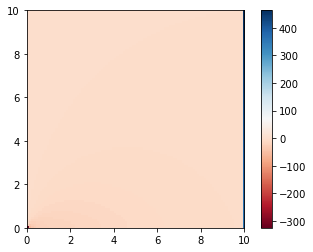

C:\Users\alegb\anaconda3\lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:1394: RuntimeWarning: divide by zero encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

C:\Users\alegb\anaconda3\lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:1394: RuntimeWarning: invalid value encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)



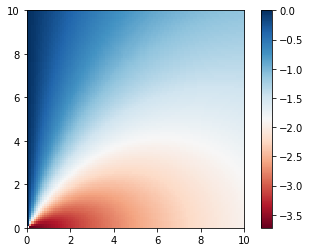

In [59]:
#Define RForce function
test_R_grid = np.linspace(0,10,100)*u.kpc
test_z_grid = np.linspace(0,10,100)*u.kpc
# def RForce(ip, r_grid, z_grid):
#     #Important note: this function takes in distances (r_grid and z_grid) and outputs an RForce in km/s/Myr, and will not output correct results if it is given parameters with other units
#
#     r_grid = r_grid[:]
#     z_grid = z_grid[:]
#     grid = np.zeros((len(r_grid),len(z_grid)))*u.km/u.s/u.Myr
#     delta = r_grid[1] - r_grid[0]
#     for i,r in enumerate(r_grid):
#         for j,z in enumerate(z_grid):
#             if delta.unit != r.unit:
#                 print(delta, r)
#             grid[j][i] = (((ip._evaluate((r+delta).value,z.value) - ip._evaluate((r).value,z.value)) / (delta.to(u.km).value)) * u.km/u.s**2).to(u.km/u.s/u.Myr)
#
#     # for i,r in enumerate(r_grid):
#     #     delta = (r_grid[1] - r_grid[0]).value
#     #     grid[:,i] = (ip._evaluate(np.array(np.ones((len(r_grid),))*r.value+delta), np.array(z_grid.value)) - ip._evaluate(np.ones((len(r_grid),))*r.value, np.array(z_grid.value)))/(delta)
#     return -grid
# evaluated_R_force = RForce(ip,test_R_grid,test_z_grid)
# plt.imshow(evaluated_R_force, interpolation='nearest', extent =[test_R_grid.min().value, test_R_grid[:].max().value, test_z_grid.min().value, test_z_grid.max().value], cmap='RdBu',  origin='lower')
# plt.colorbar()
# plt.title("Rforce vs R and z")
# plt.xlabel("R (kpc)")
# plt.ylabel("z (kpc)")
# plt.show()
# plt.plot(test_R_grid[:],evaluated_R_force[0,:])
# plt.xlabel("R (kpc)")
# plt.ylabel("Radial Force ()")
# plt.title("R Force vs Radius (z=0)")
# plt.show()

new_evaluated_R_force = ip._Rforce(test_R_grid,test_z_grid)
print(new_evaluated_R_force)
plt.imshow(new_evaluated_R_force, interpolation='nearest', extent =[test_R_grid.min().value, test_R_grid[:].max().value, test_z_grid.min().value, test_z_grid.max().value], cmap='RdBu',  origin='lower')
plt.colorbar()
plt.show()

check_grid = np.zeros((len(test_R_grid),len(test_z_grid)))
for i,R in enumerate(test_R_grid):
    check_grid[:,i] = MWPotential2014[2].Rforce(R, test_z_grid, quantity=True, ro=8, vo=220)
# check_grid = MWPotential2014[2].Rforce(1*u.kpc, test_z_grid, quantity=True, ro=10,vo=100)
plt.imshow(check_grid, interpolation='nearest', extent =[test_R_grid.min().value, test_R_grid[:].max().value, test_z_grid.min().value, test_z_grid.max().value], cmap='RdBu',  origin='lower')
plt.colorbar()
plt.show()



Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
C:\Users\alegb\anaconda3\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



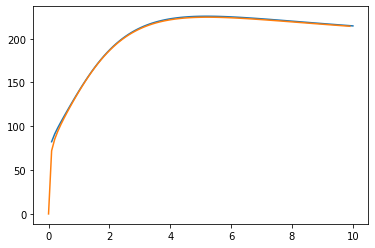

In [157]:
# Calculating the rotation curve

def vcirc(R_grid, R_force):
    v_c = np.sqrt(R_grid[:] * -R_force[0,:]).to(u.km/u.s)
    print(R_force[-1])
    return v_c


from galpy.potential import vcirc

# plt.plot(test_R_grid[:],vcirc(test_R_grid, evaluated_R_force))
plt.plot(test_R_grid[1:], vcirc(MWPotential2014, test_R_grid[1:], quantity=True, ro=8,vo=220))
        # MWPotential2014[2].vcirc(test_R_grid[1:], quantity=True, ro=10,vo=100))
plt.plot(test_R_grid, ip._vcirc(test_R_grid))

plt.show()

[-7.40740741 -7.19269995 -6.97799249 -6.76328502 -6.54857756 -6.3338701
 -6.11916264 -5.90445518 -5.68974772 -5.47504026 -5.2603328  -5.04562534
 -4.83091787 -4.61621041 -4.40150295 -4.18679549 -3.97208803 -3.75738057
 -3.54267311 -3.32796565 -3.11325819 -2.89855072 -2.68384326 -2.4691358
 -2.25442834 -2.03972088 -1.82501342 -1.61030596 -1.3955985  -1.18089104
 -0.96618357 -0.75147611 -0.53676865 -0.32206119 -0.10735373  0.10735373
  0.32206119  0.53676865  0.75147611  0.96618357  1.18089104  1.3955985
  1.61030596  1.82501342  2.03972088  2.25442834  2.4691358   2.68384326
  2.89855072  3.11325819  3.32796565  3.54267311  3.75738057  3.97208803
  4.18679549  4.40150295  4.61621041  4.83091787  5.04562534  5.2603328
  5.47504026  5.68974772  5.90445518  6.11916264  6.3338701   6.54857756
  6.76328502  6.97799249  7.19269995  7.40740741]


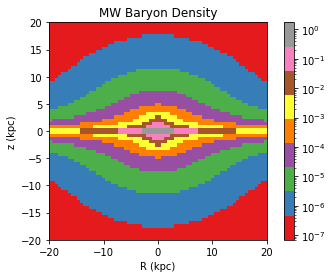

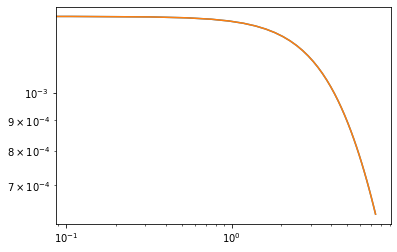

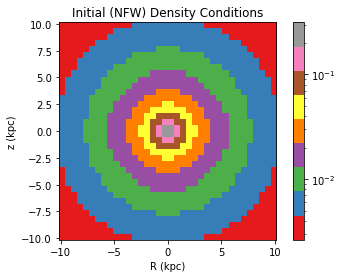

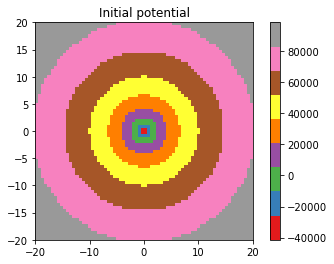

[[6.97844795e-08 7.41199411e-08 7.87045561e-08 ... 7.87045561e-08
  7.41199411e-08 6.97844795e-08]
 [7.58932567e-08 8.07439254e-08 8.58862143e-08 ... 8.58862143e-08
  8.07439254e-08 7.58932567e-08]
 [8.26237880e-08 8.80564789e-08 9.38306640e-08 ... 9.38306640e-08
  8.80564789e-08 8.26237880e-08]
 ...
 [8.26237880e-08 8.80564789e-08 9.38306640e-08 ... 9.38306640e-08
  8.80564789e-08 8.26237880e-08]
 [7.58932567e-08 8.07439254e-08 8.58862143e-08 ... 8.58862143e-08
  8.07439254e-08 7.58932567e-08]
 [6.97844795e-08 7.41199411e-08 7.87045561e-08 ... 7.87045561e-08
  7.41199411e-08 6.97844795e-08]] solMass / pc3
0.004055541231781978 0
0.003996472872243695 1
0.003938370702707195 2
0.0038812171183728594 3
0.003824994856699737 4
0.003769686990652721 5
0.003715276922071853 6
0.0036617483751617552 7
0.003609085390102962 8
0.003557272316780713 9
0.003506293808630545 10
0.0034561348166004535 11
0.0034067805832260767 12
0.0033582166368189004 13
0.0033104287857645964 14
0.0032634031129314955 15
0.003

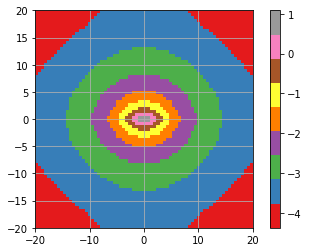

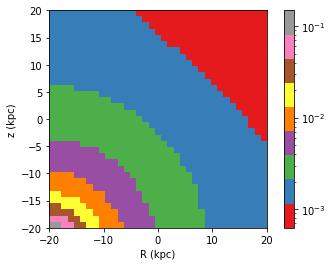

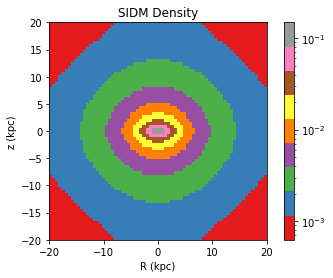

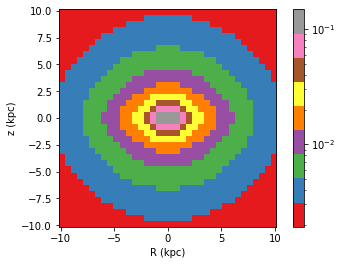

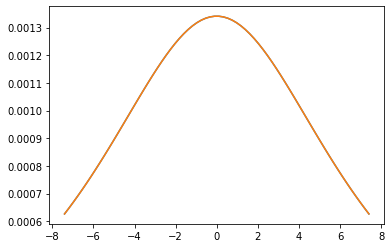

In [61]:
# Calculated density profile from PDE

from galpy.potential import NFWPotential
from galpy.potential import PowerSphericalPotentialwCutoff
from galpy.potential import MiyamotoNagaiPotential
import matplotlib
from astropy.constants import G
r_0 = 2.7 * u.kpc

rho_0 = 0.05 * u.M_sun/u.pc**3
vel_disp = 150*u.km/u.s
a0 = (4 * np.pi * G * rho_0 * r_0**2 / vel_disp**2).to('')
c=11.5


grid_size = 70

NFW_pot= MWPotential2014[2]
# #NFW_pot = NFWPotential(mvir=0.7,conc=c,
#                    H=69.2,overdens=200.,wrtcrit=True,
#                    ro=8.,vo=220.)




h = np.zeros((grid_size,grid_size))

milky_way = MWPotential2014[0:2]


from galpy.potential import evaluateDensities

R_grid = np.linspace(-20,20,grid_size)*u.kpc / r_0
print(R_grid)
z_grid = np.linspace(-20,20,grid_size)*u.kpc / r_0
for i,R in enumerate(R_grid):
    for j,z in enumerate(z_grid):
        #print(i,j)
        h[j][i] = np.log(NFW_pot.dens(R*r_0,z*r_0, quantity=True, ro=8,vo=220) / rho_0)


delta = R_grid[1] - R_grid[0]

mw_density = np.zeros((grid_size,grid_size)) *  u.M_sun/u.pc**3

for pot in milky_way:
    for i in range(grid_size):
        mw_density[i] += pot.dens(np.abs(R_grid*r_0), np.abs(z_grid[i]*r_0), quantity=True, ro=8, vo=220)
        #print(mw_density[i])
#print(np.ndim(mw_density))

rho_new = rho_0 * np.e**h



plt.imshow(mw_density, cmap='Set1', interpolation='nearest', origin='lower', norm=matplotlib.colors.LogNorm(), extent =[R_grid.min().value * r_0.value, R_grid.max().value * r_0.value, z_grid.min().value * r_0.value, z_grid.max().value * r_0.value])
plt.title('MW Baryon Density')
plt.xlabel('R (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar()
plt.show()




plt.plot(R_grid, rho_new[:,0])
plt.plot(z_grid, rho_new[0,:])
plt.loglog()
plt.show()

plt.imshow(rho_new[int(grid_size/4):-int(grid_size/4),int(grid_size/4):-int(grid_size/4)], cmap='Set1', interpolation='nearest', extent =[R_grid[int(grid_size/4):-int(grid_size/4)].min().value * r_0.value, R_grid[int(grid_size/4):-int(grid_size/4)].max().value * r_0.value, z_grid[int(grid_size/4):-int(grid_size/4)].min().value * r_0.value, z_grid[int(grid_size/4):-int(grid_size/4)].max().value * r_0.value], origin ='lower', norm=matplotlib.colors.LogNorm())
plt.title('Initial (NFW) Density Conditions')
plt.xlabel('R (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar()
plt.show()

original_h = h.copy()

plt.imshow(-h * vel_disp**2, cmap='Set1', interpolation='nearest', extent =[R_grid.min().value * r_0.value, R_grid.max().value * r_0.value, z_grid.min().value * r_0.value, z_grid.max().value * r_0.value], origin ='lower')
plt.title("Initial potential")
plt.colorbar()
plt.show()


print(mw_density)



for i in range(100000):
    h_last = h.copy()

    h[1:-1,1:-1] = 0.0002 * ((h[1:-1,2:] + h[1:-1,:-2] - 2*h[1:-1,1:-1]) / delta**2 + 1/(R_grid[1:-1]) * (h[1:-1,2:] - h[1:-1,:-2])/(2*delta) + (h[2:,1:-1] + h[:-2,1:-1] - 2*h[1:-1,1:-1]) / delta**2 + a0*(mw_density[1:-1,1:-1]/rho_0 + np.e**(h[1:-1,1:-1]))) + h[1:-1,1:-1]



    print(np.max(abs(h - h_last)), i)
    if np.max(abs(h - h_last)) < 1e-6:
        print(np.max(abs(h - h_last)))
        print(f'Solution converged in {i} steps.')
        break



rho_new = rho_0 * np.e**h
# print(h)
# print(rho_new)

plt.imshow(h, interpolation='nearest', extent =[R_grid.min().value * r_0.value, R_grid.max().value * r_0.value, z_grid.min().value * r_0.value, z_grid.max().value * r_0.value],cmap='Set1', origin='lower')
plt.colorbar()
plt.grid(True)
plt.show()


plt.imshow(rho_new[int(grid_size/2):,int(grid_size/2):], interpolation='nearest', extent =[R_grid.min().value * r_0.value, R_grid.max().value * r_0.value, z_grid.min().value * r_0.value, z_grid.max().value * r_0.value], norm=matplotlib.colors.LogNorm(), cmap='Set1',  origin='lower')
plt.xlabel('R (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar()
plt.show()

plt.imshow(rho_new[:,:], interpolation='nearest', extent =[R_grid.min().value * r_0.value, R_grid.max().value * r_0.value, z_grid.min().value * r_0.value, z_grid.max().value * r_0.value], norm=matplotlib.colors.LogNorm(), cmap='Set1',  origin='lower')
plt.xlabel('R (kpc)')
plt.ylabel('z (kpc)')
plt.title("SIDM Density")
plt.colorbar()
plt.show()


plt.imshow(rho_new[int(grid_size/4):-int(grid_size/4),int(grid_size/4):-int(grid_size/4)], interpolation='nearest', extent =[R_grid[int(grid_size/4):-int(grid_size/4)].min().value * r_0.value, R_grid[int(grid_size/4):-int(grid_size/4)].max().value * r_0.value, z_grid[int(grid_size/4):-int(grid_size/4)].min().value * r_0.value, z_grid[int(grid_size/4):-int(grid_size/4)].max().value * r_0.value], norm=matplotlib.colors.LogNorm(), cmap='Set1',  origin='lower')
plt.xlabel('R (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar()
plt.show()

plt.plot(R_grid, rho_new[:,0])
plt.plot(z_grid, rho_new[0,:])
plt.show()

R_grid = R_grid * r_0
z_grid = z_grid * r_0

In [62]:
# Interpolating MW potential

# R_grid = np.linspace(0,10,100)*u.kpc
# z_grid = np.linspace(0,10,100)*u.kpc

# vel_disp = 200 *u.km/u.s

dim_potential = - h * vel_disp**2

MW_Interp_potential = DirectInterpRZPotential(directPotentialGrid=dim_potential, directRGrid=R_grid.value, directzGrid=z_grid.value, fallbackPotential=MWPotential2014, interpPot=True, logR=False, interpDens=True, directDensGrid=rho_new)
# orig_interp_potential = DirectInterpRZPotential(directPotentialGrid=-original_h*vel_disp**2, directRGrid=R_grid.value, directzGrid=z_grid.value, fallbackPotential=MWPotential2014, interpPot=True, logR=False)


print(dim_potential)


[[98534.37203281 97792.94094251 97054.35150436 ... 97054.35150436
  97792.94094251 98534.37203281]
 [97792.94094251 97080.08907736 96363.19148232 ... 96363.19148232
  97080.08907736 97792.94094251]
 [97054.35150436 96362.11349581 95663.18860857 ... 95663.18860857
  96362.11349581 97054.35150436]
 ...
 [97054.35150436 96362.11349581 95663.18860857 ... 95663.18860857
  96362.11349581 97054.35150436]
 [97792.94094251 97080.08907736 96363.19148232 ... 96363.19148232
  97080.08907736 97792.94094251]
 [98534.37203281 97792.94094251 97054.35150436 ... 97054.35150436
  97792.94094251 98534.37203281]] km2 / s2


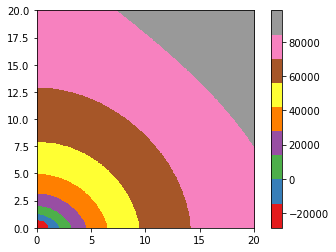

[-2325.85168277]
[59009.68536928]
[59009.68571084]


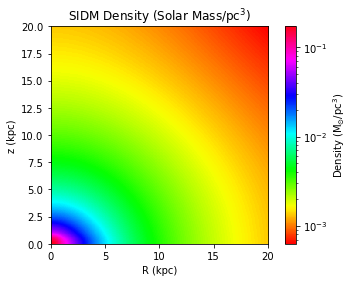

<Figure size 1800x1200 with 0 Axes>

In [63]:
test_R_grid = np.linspace(0,20,500)*u.kpc
test_z_grid = np.linspace(0,20,500)*u.kpc
potential_grid = np.zeros((500,500))
for i,R in enumerate(test_R_grid):
    for j,z in enumerate(test_z_grid):
        potential_grid[j][i] = MW_Interp_potential._evaluate(R.value,z.value)
plt.imshow(potential_grid, interpolation='nearest', extent =[test_R_grid.min().value, test_R_grid.max().value, test_z_grid.min().value, test_z_grid.max().value], cmap='Set1',  origin='lower')
plt.colorbar()
plt.show()

print(MW_Interp_potential._evaluate(np.array([10.]),np.array([1])) - MW_Interp_potential._evaluate(np.array([10.0000001]),np.array([3])))
print(MW_Interp_potential._evaluate(np.array([10.]),np.array([1])))
print(MW_Interp_potential._evaluate(np.array([10.0000001]),np.array([1])))

interp_dens = np.zeros((500,500))

for i,R in enumerate(test_R_grid):
    for j,z in enumerate(test_z_grid):
        interp_dens[j][i] = MW_Interp_potential.dens_eval(R.value,z.value)

plt.imshow(interp_dens,interpolation='nearest', extent =[test_R_grid.min().value, test_R_grid.max().value, test_z_grid.min().value, test_z_grid.max().value], norm=matplotlib.colors.LogNorm(), cmap='hsv',  origin='lower' )
plt.colorbar(label=r"Density (M$_{\odot}$/pc$^3$)")

plt.title(r"SIDM Density (Solar Mass/pc$^3$)")
plt.xlabel("R (kpc)")
plt.ylabel("z (kpc)")
plt.figure(dpi=300)

plt.show()

In [ ]:
import csv

csv_filename = "DensityProfile.csv"

with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(interp_dens)

print(f"Arrays written to {csv_filename}")


In [ ]:
csv_filename = "DensityProfile.csv"  # Replace with your CSV filename
data = []
with open(csv_filename, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        data.append([float(val) for val in row])

# Convert the data to a NumPy array
data_array = np.array(data)
plt.imshow(data_array,interpolation='nearest', extent =[test_R_grid.min().value, test_R_grid[:].max().value, test_z_grid.min().value, test_z_grid.max().value], cmap='hsv',  origin='lower', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(-MW_Interp_potential._Rforce(test_R_grid, test_z_grid),interpolation='nearest', extent =[test_R_grid.min().value, test_R_grid[:].max().value, test_z_grid.min().value, test_z_grid.max().value], cmap='RdBu',  origin='lower', norm=matplotlib.colors.LogNorm())
plt.title("Rforce")
plt.xlabel("R (kpc)")
plt.ylabel("z (kpc)")
plt.colorbar()
plt.show()



Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
C:\Users\alegb\anaconda3\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

[ 73.68823066  79.97619021  84.33883985  87.91961947  91.08996777
  94.01746298  96.79111424  99.4629563  102.06527791 104.61885903
 107.13733196 109.62967475 112.10172475 114.55714288 116.99805251
 119.42547687 121.8396466  124.24022117 126.62645103 128.99729852
 131.35152887 133.68777959 136.00461368 138.30056061 140.57414798
 142.82392601 145.04848629 147.24647614 149.41660944 151.55767453
 153.66853991 155.74815806 157.79556773 159.80989504 161.79035362
 163.73624382 165.64695139 167.52194559 169.36077682 171.16307397
 172.92854153 174.65695641 176.3481647  178.00207828 179.61867135
 181.19797703 182.7400838  184.2451321  185.71331088 187.14485427
 188.54003829 189.89917759 191.

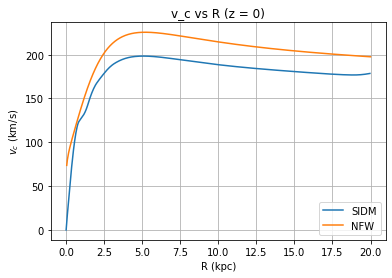

In [64]:
from galpy.potential import vcirc

test_R_grid = np.linspace(0,20,500)*u.kpc
test_z_grid = np.linspace(0,20,500)*u.kpc

plt.plot(test_R_grid[:], MW_Interp_potential._vcirc(test_R_grid[:]))

# print(test_R_grid)
# print(MW_Interp_potential._vcirc(test_R_grid))
#plt.plot(test_R_grid[:], orig_interp_potential._vcirc(test_R_grid[:]))
plt.plot(test_R_grid[1:], vcirc(MWPotential2014[:], test_R_grid[1:], quantity=True, ro=8,vo=220))


print(vcirc(MWPotential2014, test_R_grid[1:], quantity=True, ro=8,vo=220))
print(test_R_grid)
#plt.plot(test_R_grid, MWPotential2014[0].vcirc(test_R_grid, ro=10, vo=100, quantity=True) + MWPotential2014[1].vcirc(test_R_grid, ro=10, vo=100, quantity=True) + MWPotential2014[2].vcirc(test_R_grid, ro=10, vo=100, quantity=True))
plt.title("v_c vs R (z = 0)")
# plt.yscale("log")
plt.xlabel("R (kpc)")
plt.ylabel(f"$v_c$ (km/s)")
plt.legend(["SIDM", "NFW", "galpy"])
plt.grid(True)
plt.show()

Fallback potential used rather than interpolation, because requested coordinates are outside the provided grid.
C:\Users\alegb\anaconda3\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

[ 73.68823066  79.97619021  84.33883985  87.91961947  91.08996777
  94.01746298  96.79111424  99.4629563  102.06527791 104.61885903
 107.13733196 109.62967475 112.10172475 114.55714288 116.99805251
 119.42547687 121.8396466  124.24022117 126.62645103 128.99729852
 131.35152887 133.68777959 136.00461368 138.30056061 140.57414798
 142.82392601 145.04848629 147.24647614 149.41660944 151.55767453
 153.66853991 155.74815806 157.79556773 159.80989504 161.79035362
 163.73624382 165.64695139 167.52194559 169.36077682 171.16307397
 172.92854153 174.65695641 176.3481647  178.00207828 179.61867135
 181.19797703 182.7400838  184.2451321  185.71331088 187.14485427
 188.54003829 189.89917759 191.

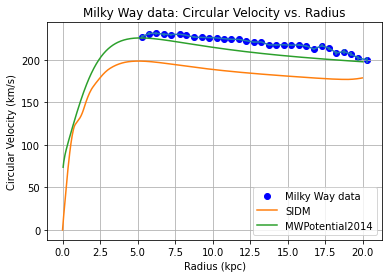

<Figure size 1800x1200 with 0 Axes>

In [65]:

# Read data from the file and extract first two columns
file_path = "data.txt"

# Lists to store the data from the first two columns
column1_data = []
column2_data = []
column3_data = []
column4_data = []

# Read data from the file and populate the lists
with open(file_path, "r") as file:
    for line in file:
        # Split the line by whitespace and convert the values to float
        try:
            values = [float(val) for val in line.strip().split()]
            if len(values) >= 2:
                column1_data.append(values[0])
                column2_data.append(values[1])
                column3_data.append(values[2])
                column4_data.append(values[3])
        except:
            pass
error = np.row_stack([column3_data[:-7], column4_data[:-7]])
# Create a scatter plot
plt.scatter(column1_data[:-7], column2_data[:-7], marker='o', color='b', label='Data Points')
plt.errorbar(column1_data[:-7], column2_data[:-7], yerr=error)



plt.xlabel('Radius (kpc)')
plt.ylabel('Circular Velocity (km/s)')
plt.title('Milky Way data: Circular Velocity vs. Radius')
plt.grid(True)

plt.plot(test_R_grid[:], MW_Interp_potential._vcirc(test_R_grid[:]))
# print(test_R_grid)
# print(MW_Interp_potential._vcirc(test_R_grid))
# plt.plot(test_R_grid[:], orig_interp_potential._vcirc(test_R_grid[:]))
plt.plot(test_R_grid[1:], vcirc(MWPotential2014, test_R_grid[1:], quantity=True, ro=8,vo=220))

print(vcirc(MWPotential2014, test_R_grid[1:], quantity=True, ro=8,vo=220))

plt.legend(["Milky Way data", "SIDM", "MWPotential2014"])
plt.figure(dpi=300)
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

# Display the plot
plt.show()

In [13]:
# converting density into a potential

from galpy.potential import interpRZPotential
import time

angle_grid = np.linspace(0,2*np.pi,10)

# for dens in rho_new:
#     mass_grid =
grav_potential = 0

r_grid = np.linspace(0,10,grid_size)*u.kpc
z_grid = np.linspace(0,10,grid_size)*u.kpc
delta = r_grid[1]-r_grid[0]

pot_r_grid = np.linspace(0,10,5)*u.kpc
pot_z_grid = np.linspace(0,10,5)*u.kpc
pot_grid = np.zeros((5,5))*u.km**2/u.s**2

start = time.time()
for n,r1 in enumerate(pot_r_grid):
    for m,z1 in enumerate(pot_z_grid):
        grav_potential = 0
        for i,r in enumerate(r_grid):
            for j,z in enumerate(z_grid):
                for theta in angle_grid:
                    dv = r*delta**2*(angle_grid[1]-angle_grid[0])
                    dist = np.sqrt(r1**2 + r**2 - 2*r1*r*np.cos(theta) + (z1 - z)**2)
                    if dist != 0:
                        grav_potential += -G * (rho_new[j][i] * dv)/dist
        print(n,m)
        pot_grid[m][n] = grav_potential.to(u.km**2/u.s**2)
finish = time.time()
print(grav_potential.to(u.km**2/u.s**2))
print(finish - start)

plt.plot(pot_r_grid, pot_grid)
plt.show()



KeyboardInterrupt: 

[[-23916.54541763 -22242.70535899 -19281.13226233 -16487.22633515
  -12731.28361594]
 [-23604.75929586 -23769.55924359 -21687.36153066 -18759.15314266
  -14538.89885513]
 [-20835.89141999 -21240.72278762 -20168.54163627 -17946.30012388
  -14187.9356838 ]
 [-17720.75111398 -18107.91693149 -17516.73100878 -15970.17005954
  -13042.51899404]
 [-14353.66183214 -14558.98825736 -14089.73387821 -13011.58012617
  -10920.76223932]] km2 / s2


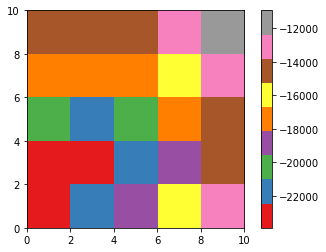

-20118.81682326813
